# Intro

Сегодня мы поговорим о сверточных нейросетях.

Сначала поймем суть _`convolutions`_, а затем попробуем решить реальную задачу по классификации объявлений на _Avito_.

Если вы смотрите этот ноутбук, то вероятно ваш семинарист где-то рядом и как раз объясняет что к чему.


In [1]:
# --------- Just imports to make everything ok --------------


import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
%matplotlib inline

def reset_graph(seed=42):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)

# Для красивого вывода графиков и картиночек
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
plt.rcParams['axes.titlesize'] = 30

# Если хотите можете
# написать тут более подходящее место
# для сохранения картиночек
PROJECT_ROOT_DIR = "."

def save_fig(fig_id, tight_layout=True):
    path = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID, fig_id + ".png")
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format='png', dpi=300)

# Еще пара вспомогательных функций, чтобы красиво отображать grayscale & RGB
def plot_image(image):
    plt.imshow(image, cmap="gray", interpolation="nearest")
    plt.axis("off")

def plot_color_image(image):
    plt.imshow(image.astype(np.uint8),interpolation="nearest")
    plt.axis("off")

И конечно tf

In [2]:
import tensorflow as tf

In [3]:
print(tf.__version__)

1.3.0


# Что такое свертки и с чем их едят


Ожидается, что на данном этапе семинарист объяснил вам у доски что же такое свертки.

Прилагается немного картинок.

Про `padding` -- "SAME" & "VALID" обозначения использующиеся в tf, Keras и мб где-то еще.
* "SAME" -- это добивание нулями входной матрицы так, чтобы возможно было учесть в свертке все пиксели.
* "VALID" -- просто игнорируем те пиксели, которые не попадают в свертку. Нулей не добавляем.

<img src="./pics/padding.png" width="50%">

__strides__ -- это массив параметров, указывающих на сколько мы сдвигаемся по горизонтали и вертикали при пробегании входной матрицы сверткой.
<img src="./pics/strides.png" width="50%">

Картинка, чтобы было понятно, что один сверточный слой состоит из кучи различных карт фильтров.
А каждый нейрон из $n+1$ слоя связан со всеми подслоями из $n$-ого слоя.

<img src="./pics/deep_conv.png" width="40%">


# Фильтры

Это фильтры, которые мы будем накладывать с помощью сверток:


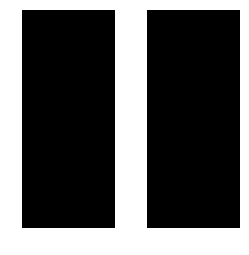

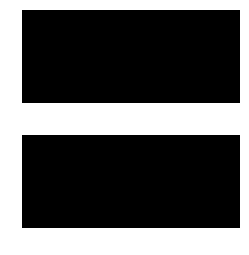

In [4]:
from sklearn.datasets import load_sample_image
china = load_sample_image("china.jpg")
flower = load_sample_image("flower.jpg")
image = china[150:220, 130:250]
height, width, channels = image.shape
image_grayscale = image.mean(axis=2).astype(np.float32)
images = image_grayscale.reshape(1, height, width, 1)
print("Это фильтры, которые мы будем накладывать с помощью сверток:")


fmap = np.zeros(shape=(7, 7, 1, 2), dtype=np.float32)
fmap[:, 3, 0, 0] = 1
fmap[3, :, 0, 1] = 1
fmap[:, :, 0, 0]
plot_image(fmap[:, :, 0, 0])
plt.show()
plot_image(fmap[:, :, 0, 1])
plt.show()

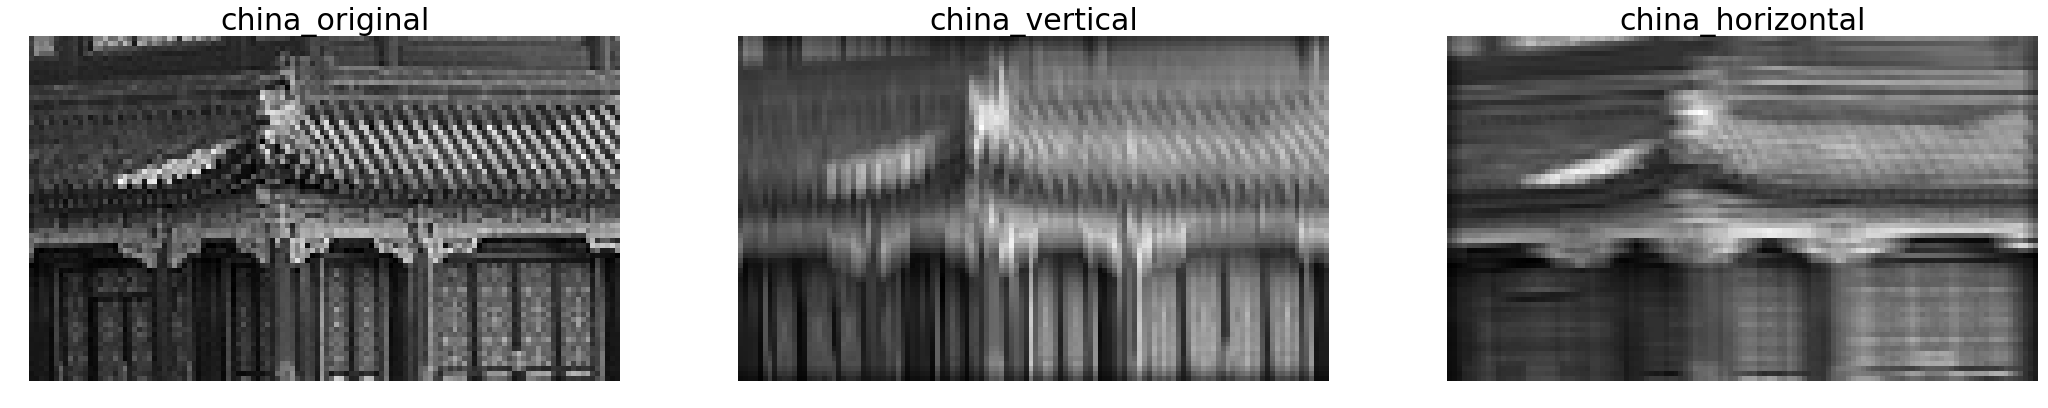

In [5]:
reset_graph()

X = tf.placeholder(tf.float32, shape=(None, height, width, 1))
feature_maps = tf.constant(fmap)
convolution = tf.nn.conv2d(X, feature_maps, strides=[1,1,1,1], padding="SAME", use_cudnn_on_gpu=False)

with tf.Session() as sess:
    output = convolution.eval(feed_dict={X: images})

    
# Отобразим результат

fig = plt.figure(figsize=(36, 12))

ax = fig.add_subplot(1, 3, 1)
plot_image(images[0, :, :, 0])
ax.set_title("china_original", )
ax.grid('off')
ax.axis('off')

ax = fig.add_subplot(1, 3, 2)
plot_image(output[0, :, :, 0])
ax.set_title("china_vertical")
ax.grid('off')
ax.axis('off')

ax = fig.add_subplot(1, 3, 3)
plot_image(output[0, :, :, 1])
ax.set_title("china_horizontal")
ax.grid('off')
ax.axis('off')

plt.show()

Теперь посмотрим что будет, если наложить сразу 2 таких фильтра:

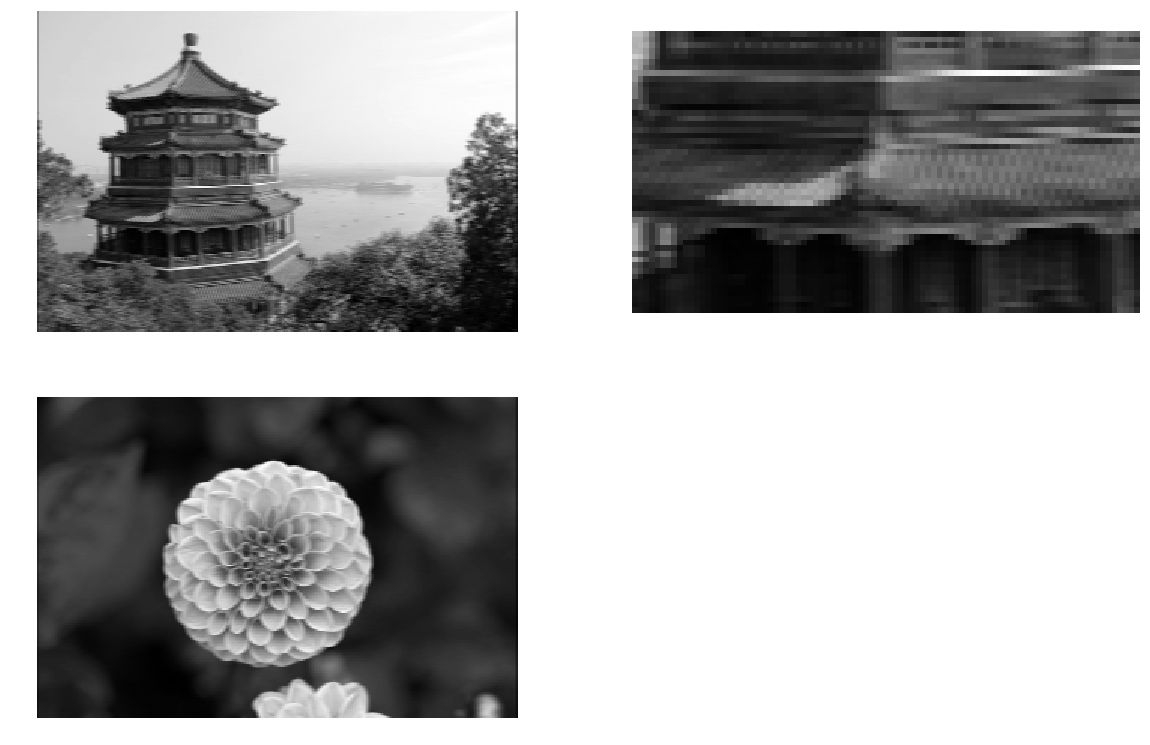

In [6]:
dataset = np.array([china, flower], dtype=np.float32)
# dataset = np.array([image], dtype=np.float32)
batch_size, height, width, channels = dataset.shape

# Create 2 filters
filters = np.zeros(shape=(7, 7, channels, 2), dtype=np.float32)
filters[:, 3, :, 0] = 1  # vertical line
filters[3, :, :, 1] = 1  # horizontal line

# Create a graph with input X plus a convolutional layer applying the 2 filters
X = tf.placeholder(tf.float32, shape=(None, height, width, channels))
convolution = tf.nn.conv2d(X, filters, strides=[1,2,2,1], padding="SAME")

with tf.Session() as sess:
    output = sess.run(convolution, feed_dict={X: dataset})
    
fig = plt.figure(figsize=(20, 13))

ax = fig.add_subplot(2, 2, 1)
plot_image(output[0, :, :, 1]) # Второй feature-map первой картинки

ax = fig.add_subplot(2, 2, 2)
plot_image(output[0, 110:160, 45:135, 1])

ax = fig.add_subplot(2, 2, 3)
plot_image(output[1, :, :, 1]) # Второй feature-map второй картинки

plt.show()

В tf.layers.conv2d веса фильтров первоначально инициализируются рандомно путем сэмплирования из равномерного распределения (glorot uniform)

Посмотрим как будет выглядеть картинка, если к ней сразу применить такие фильтры.

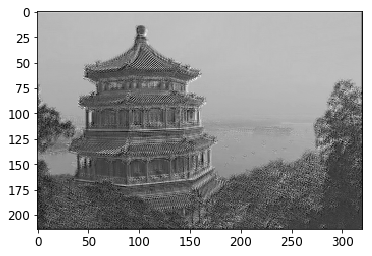

In [7]:
reset_graph()

X = tf.placeholder(shape=(None, height, width, channels), dtype=tf.float32)
conv = tf.layers.conv2d(X, filters=2, kernel_size=7, strides=[2,2],
                        padding="SAME")

init = tf.global_variables_initializer()

with tf.Session() as sess:
    init.run()
    output = sess.run(conv, feed_dict={X: dataset})
    
plt.imshow(output[0, :, :, 1], cmap="gray") # Второй feature-map
plt.show()

---

# Max pooling / Average pooling

<img src="./pics/maxPool.png" width="80%">

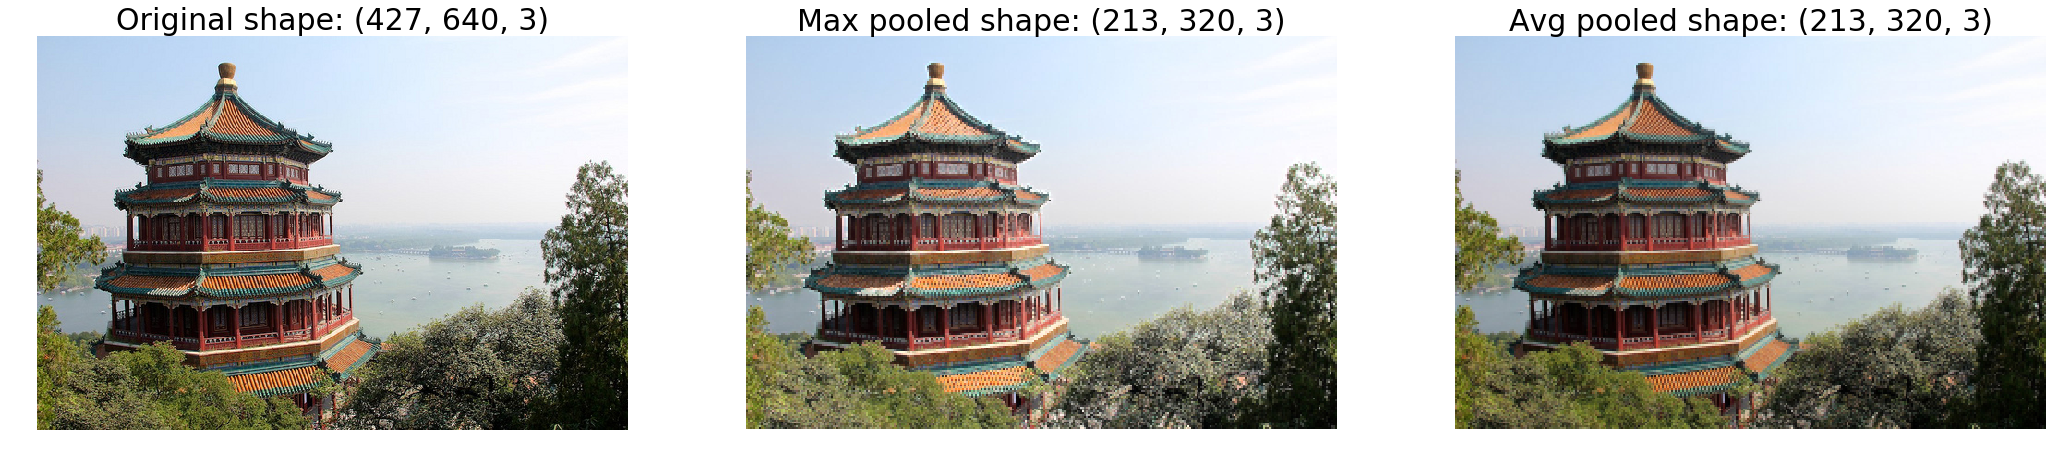

In [8]:
X = tf.placeholder(tf.float32, shape=(None, height, width, channels))

# strides=[1,2,2,1] -- означает, что pooling делается как на картинке сверху
max_pool = tf.nn.max_pool(X, ksize=[1,2,2,1], strides=[1,2,2,1],padding="VALID")
avg_pool = tf.nn.avg_pool(X, ksize=[1,2,2,1], strides=[1,2,2,1],padding="VALID")


with tf.Session() as sess:
    output_m, output_avg = sess.run([max_pool, avg_pool], feed_dict={X: dataset})

fig = plt.figure(figsize=(36, 12))

ax = fig.add_subplot(1, 3, 1)
plot_color_image(dataset[0])
ax.set_title("Original shape: {}".format(dataset[0].shape))

ax = fig.add_subplot(1, 3, 2)
plot_color_image(output_m[0])
ax.set_title("Max pooled shape: {}".format(output_m[0].shape))

ax = fig.add_subplot(1, 3, 3)
plot_color_image(output_avg[0])
ax.set_title("Avg pooled shape: {}".format(output_avg[0].shape))

plt.show()

# Avito challenge

Конечно, сама идея сверточных нейросетей исходит из анализа работы органов зрения. Поэтому не удивительно, что свертки отлично справляются с анализом изображений. Но их также можно применять для анализа последовательностей. Для этого есть одномерные свертки. И они тоже очень неплохо работают.

Сейчас предлагается опробовать свои силы в решении реальной задачи по классификации объявлений на Avito.
![caption](https://kaggle2.blob.core.windows.net/competitions/kaggle/3929/media/Ad.png)

# Познакомимся с данными

Бывший kaggle-конкурс про выявление нежелательного контента.

Описание конкурса есть тут - https://www.kaggle.com/c/avito-prohibited-content

Сегодня мы будем пользоваться прореженными train данными чтобы даже те, у кого небольшой RAM (~4Gb) смогли нормально работать.
Оригинальные данные все еще доступны для скачивания на Kaggle.
 
Много разных признаков:
* 2 вида текста - заголовок и описание
* Много специальных фичей - цена, количество телефонов/ссылок/e-mail адресов
* Категория и субкатегория - как ни странно, категориальные фичи
* Аттрибуты - много категориальных признаков

Нужно предсказать всего 1 бинарный признак - есть ли в рекламе нежелательный контент.
* Под нежелательным контентом понимается криминал, прон, афера, треска и прочие любимые нами темы.
* Да, если присмотреться к заблокированным объявлениям, можно потерять аппетит и сон на пару дней.
* Однако профессия аналитика данных обязывает вас смотреть на данные.
 * А кто сказал, что будет легко? Data Science - опасная профессия.

Если у вас очень мало памяти (~4Gb), то поставьте флаг __`very_low_ram = True`__

In [9]:
very_low_ram = False

In [31]:
df = pd.read_csv("avito_train_1kk.tsv", sep='\t')

In [11]:
print(df.shape, df.is_blocked.mean())
df[:5]

(1204949, 13) 0.22822210732570425


,itemid,category,subcategory,title,description,attrs,price,is_proved,is_blocked,phones_cnt,emails_cnt,urls_cnt,close_hours
0,10000010,Транспорт,Автомобили с пробегом,"Toyota Sera, 1991",Новая оригинальная линзованая оптика на ксенон...,"{""Год выпуска"":""1991"", ""Тип кузова"":""Купе"", ""П...",150000,NaN,0,0,0,0,0.03
1,10000094,Личные вещи,"Одежда, обувь, аксессуары",Костюм Steilmann,Юбка и топ из панбархата. Под топ трикотажная...,"{""Вид одежды"":""Женская одежда"", ""Предмет одежд...",1500,NaN,0,0,0,0,0.41
2,10000299,Личные вещи,Детская одежда и обувь,"Костюм Didriksons Boardman, размер 100, краги,...","Костюм Didriksons Boardman, в отличном состоян...","{""Вид одежды"":""Для мальчиков"", ""Предмет одежды...",3000,NaN,0,0,0,0,5.49
3,10000309,Недвижимость,Квартиры,"1-к квартира, 44 м², 9/20 эт.","В кирпичном пан.-м доме, продается одноком.-ая...","{""Тип объявления"":""Продам"", ""Количество комнат...",2642020,NaN,0,1,0,0,22.47
4,10000317,Услуги,Предложения услуг,"Поездки на таможню, печать в паспорте",Поездки на таможню гражданам СНГ для пересечен...,"{""Вид услуги"":""Деловые услуги"", ""Тип услуги"":""...",1500,0.0,1,0,0,0,1.43


In [4]:
df[df.is_blocked]

NameError: name 'df' is not defined

In [13]:
import pandas

# Сбалансируем выборку

* Выборка смещена в сторону незаблокированных объявлений
 * 4 миллиона объявлений и только 250 тысяч заблокированы.
 * Давайте просто выберем случайные 250 тысяч незаблокированных объявлений и сократим выборку до полумилиона.
 * В последствии можно испоьзовать более умные способы сбалансировать выборку


__Если у вас слабый ПК и вы видите OutOfMemory, попробуйте уменьшить размер выборки до 100 000 примеров__

__Алсо если вы не хотите ждать чтения всех данных каждый раз - сохраните уменьшенную выборку и читайте её__

In [35]:
df_bad = df[df.is_blocked == 1]
df_good = df[df.is_blocked == 0][:len(df_bad)]
df = df_bad.append(df_good)

In [36]:
assert df.is_blocked.mean() < 0.51
assert df.is_blocked.mean() > 0.49
assert len(df) <= 560000

print("All tests passed")

All tests passed


In [ ]:
#прореживаем данные ещё в 2 раза, если памяти не хватает
if very_low_ram:
    data = data[::2]

# Токенизируем примеры

Сначала соберём словарь всех возможных слов.
Поставим каждому слову в соответствие целое число - его id

#### NLTK

Для работы этого семинара вам потреюуется nltk v3.2

__Важно, что именно v3.2, чтобы правильно работал токенизатор__

Устаовить/обновиться до неё можно командой
* `sudo pip install --upgrade nltk==3.2`
* Если у вас старый pip, предварительно нужно сделать `sudo pip install --upgrade pip`

Если у вас нет доступа к этой версии - просто убедитесь, что токены в token_counts включают русские слова.

In [60]:
from nltk.tokenize import RegexpTokenizer
from collections import Counter,defaultdict
tokenizer = RegexpTokenizer(r"\w+")

#словарь для всех токенов
token_counts = Counter()

#все заголовки и описания
all_texts = np.hstack([df.description.values,df.title.values])


#считаем частоты слов
for s in all_texts:
    if type(s) is not str:
        continue
    s = s.lower()
    tokens = tokenizer.tokenize(s)
    for token in tokens:
        token_counts[token] +=1

In [74]:
a = {1:2,4:1,5:0}
sorted(list(a.items()), key=lambda x: x[1])

[(5, 0), (4, 1), (1, 2)]

### Вырежем редкие токены


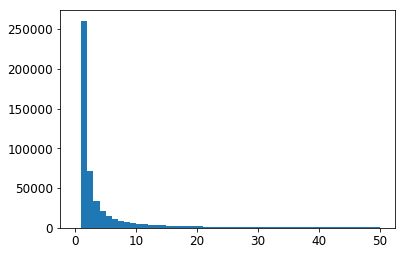

In [38]:
#распределение частот слов - большинство слов встречаются очень редко - для нас это мусор
plt.hist(list(token_counts.values()), range=[0,50], bins = 50)
plt.show()

In [61]:
len(token_counts)

521989

In [76]:
#возьмём только те токены, которые встретились хотя бы 10 раз в обучающей выборке
#информацию о том, сколько раз встретился каждый токен, можно найти в словаре token_counts

min_count = 10
x = 0
a = sorted(list(token_counts.items()), key=lambda x: x[1])
for i in a:
    if i[1] >10:
        break
    x+=1
a = a[x:]

[('моделировать', 11), ('ветеранский', 11), ('прослушивающие', 11), ('выберет', 11), ('первенство', 11), ('залу', 11), ('отменить', 11), ('лыжам', 11), ('ирси', 11), ('dva', 11), ('восстанавливающего', 11), ('3mpx', 11), ('беспокоитесь', 11), ('66000', 11), ('предусмотрна', 11), ('диагностируемого', 11), ('кобре', 11), ('магнелис', 11), ('вагините', 11), ('эбен', 11), ('cоcтoянии', 11), ('межповерочный', 11), ('ожидаете', 11), ('решаема', 11), ('потрепан', 11), ('промокод', 11), ('950000', 11), ('g7', 11), ('2840', 11), ('балканский', 11), ('ловушку', 11), ('ub', 11), ('делит', 11), ('сколеоз', 11), ('калифорнии', 11), ('радиусные', 11), ('обученные', 11), ('фасции', 11), ('60hrc', 11), ('флаги', 11), ('металом', 11), ('invisible', 11), ('документи', 11), ('кресси', 11), ('эстер', 11), ('вместительное', 11), ('решительность', 11), ('изогнутой', 11), ('рождается', 11), ('предметный', 11), ('проверит', 11), ('джея', 11), ('круговые', 11), ('расширяю', 11), ('абхъянга', 11), ('маркам', 11

In [90]:
token_to_id = {t:i+1 for i,t in enumerate(a)}
null_token = "NULL"
token_to_id[null_token] = 0


In [91]:
print("Всего токенов:",len(token_to_id))
if len(token_to_id) < 30000:
    print("Алярм! Мало токенов. Проверьте, есть ли в token_to_id юникодные символы, если нет - обновите nltk или возьмите другой токенизатор")
if len(token_to_id) > 1000000:
    print("Алярм! Много токенов. Если вы знаете, что делаете - всё ок, если нет - возможно, вы слишком слабо обрезали токены по количеству")

Всего токенов: 83014


### Заменим слова на их id
Для каждого описания установим максимальную длину. 
 * Если описание больше длины - обрежем, если меньше - дополним нулями.
 * Таким образом, у нас получится матрица размера (число объявлений)x(максимальная длина)
 * Элемент под индексами i,j - номер j-того слова i-того объявления

In [95]:
def vectorize(strings, token_to_id, max_len=150):
    token_matrix = []
    for s in strings:
        if type(s) is not str:
            token_matrix.append([0]*max_len)
            continue
        s = s.lower()
        tokens = tokenizer.tokenize(s)
        token_ids = list(map(lambda token: token_to_id.get(token,0), tokens))[:max_len]
        token_ids += [0]*(max_len - len(token_ids))
        token_matrix.append(token_ids)

    return np.array(token_matrix)

In [93]:
desc_tokens = vectorize(df.description.values,token_to_id,max_len = 150)
title_tokens = vectorize(df.title.values,token_to_id,max_len = 15)

### Пример формата данных

In [94]:
print("Размер матрицы:",title_tokens.shape)
for title, tokens in zip(df.title.values[:3],title_tokens[:3]):
    print(title,'->', tokens[:10],'...')

Размер матрицы: (549992, 15)
Поездки на таможню, печать в паспорте -> [0 0 0 0 0 0 0 0 0 0] ...
Рефлекторно-урогинекологический массаж -> [0 0 0 0 0 0 0 0 0 0] ...
Возьму суду под200 т. р -> [0 0 0 0 0 0 0 0 0 0] ...


__ Как вы видите, всё довольно грязно. Посмотрим, сожрёт ли это нейронка __

# Нетекстовые признаки

Часть признаков не являются строками текста: цена, количество телефонов, категория товара.

Их можно обработать отдельно.

In [96]:
#Возьмём числовые признаки
df_numerical_features = df[["phones_cnt","emails_cnt","urls_cnt","price"]]


#Возьмём one-hot encoding категорий товара.
#Для этого можно использовать DictVectorizer (или другой ваш любимый препроцессор)

from sklearn.feature_extraction import DictVectorizer

categories = []
for cat_str, subcat_str in df[["category","subcategory"]].values:
    
    cat_dict = {"category":cat_str, "subcategory":subcat_str}
    categories.append(cat_dict)

vectorizer = DictVectorizer(sparse=False)
cat_one_hot = vectorizer.fit_transform(categories)
cat_one_hot = pd.DataFrame(cat_one_hot, columns=vectorizer.feature_names_)

In [97]:
df_non_text = pd.merge(
    df_numerical_features, cat_one_hot, on = np.arange(len(cat_one_hot))
)
del df_non_text["key_0"]

In [98]:
df_non_text.head()

,phones_cnt,emails_cnt,urls_cnt,price,category=Бытовая электроника,category=Для бизнеса,category=Для дома и дачи,category=Животные,category=Личные вещи,category=Недвижимость,...,subcategory=Резюме,subcategory=Ремонт и строительство,subcategory=Собаки,subcategory=Спорт и отдых,subcategory=Телефоны,subcategory=Товары для детей и игрушки,subcategory=Товары для животных,subcategory=Товары для компьютера,subcategory=Фототехника,subcategory=Часы и украшения
0,0,0,0,1500,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0,0,0,1000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1,1,0,0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0,0,0,18,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# Поделим данные на обучение и тест

In [99]:
#целевая переменная - есть заблокирован ли контент
target = df.is_blocked.values.astype('int32')

#закодированное название
title_tokens = title_tokens.astype('int32')

#закодированное описание
desc_tokens = desc_tokens.astype('int32')

#все нетекстовые признаки
df_non_text = df_non_text.astype('float32')

In [100]:
#поделим всё это на обучение и тест

from sklearn.model_selection import train_test_split
data_tuple = train_test_split(title_tokens,desc_tokens,df_non_text.values,target)

title_tr,title_ts,desc_tr,desc_ts,nontext_tr,nontext_ts,target_tr,target_ts = data_tuple

## Сохраним данные [опционально] 

* В этот момент вы можете сохранить все НУЖНЫЕ данные на диск и перезапусатить тетрадку, после чего считать их - чтобы выкинуть всё ненужное.
 * рекомендуется, если у вас мало памяти
* Для этого нужно один раз выполнить эту клетку с save_prepared_data=True. После этого можно начинать тетрадку с ЭТОЙ табы в режиме read_prepared_data=True

In [5]:
save_prepared_data = False #сохранить
read_prepared_data = True #cчитать

#за 1 раз данные можно либо записать, либо прочитать, но не и то и другое вместе
assert not (save_prepared_data and read_prepared_data)


if save_prepared_data:
    print("Сохраняем подготовленные данные... (может занять до 3 минут)")

    import pickle
    with open("preprocessed_data.pcl",'wb') as fout:
        pickle.dump(data_tuple,fout)
    with open("token_to_id.pcl",'wb') as fout:
        pickle.dump(token_to_id,fout)

    print("готово")
    
elif read_prepared_data:
    print("Читаем сохранённые данные...")
    
    import pickle
    
    with open("preprocessed_data.pcl",'rb') as fin:
        data_tuple = pickle.load(fin)
    title_tr,title_ts,desc_tr,desc_ts,nontext_tr,nontext_ts,target_tr,target_ts = data_tuple
    with open("token_to_id.pcl",'rb') as fin:
        token_to_id = pickle.load(fin)


        
    #повторно импортируем библиотеки, чтобы было удобно перезапускать тетрадку с этой клетки
    import pandas as pd
    import numpy as np
    import matplotlib.pyplot as plt
    %matplotlib inline

        
    print("готово")

Читаем сохранённые данные...
готово


# Поучим нейронку

Поскольку у нас есть несколько источников данных, наша нейронная сеть будет немного отличаться от тех, что вы тренировали раньше.

* Отдельный вход для заголовка
 * свёртка + global max pool или RNN
* Отдельный вход для описания
 * свёртка + global max pool или RNN
* Отдельный вход для категориальных признаков
 * обычные полносвязные слои или какие-нибудь трюки
 
Всё это нужно как-то смешать - например, сконкатенировать

* Выход - обычный двухклассовый выход
 * 1 сигмоидальный нейрон и binary_crossentropy
 * 2 нейрона с softmax и categorical_crossentropy - то же самое, что 1 сигмоидальный
 * 1 нейрон без нелинейности (lambda x: x) и hinge loss
 
Предлагается для создания архитектуры и решения текущей задачи использовать __Keras__ в качестве высокоуровневой абстракции над tf.
В Keras быстрее и проще прототипировать несложные архитектуры и он вполне справится с решением текущей задачи.
 

In [29]:
from keras.layers import Input, Dense, Concatenate
from keras.layers.core import Dropout
from keras.layers.embeddings import Embedding
from keras.layers.convolutional import Conv1D
from keras.layers.pooling import GlobalMaxPooling1D
from keras.regularizers import l2
from keras.activations import relu
from keras.models import Model

In [30]:
# Пусть сессия Keras будет привязана к сессии Tf,
# Чтобы если понадобится было возможно использовать модель Keras в Tf.

import tensorflow as tf
sess = tf.Session()

from keras import backend as K
K.set_session(sess)

In [31]:
## это три разных входа нейроночки

title_inp = Input(shape=(title_tr.shape[1],), name='Title_input', dtype='int32')
descr_inp = Input(shape=(desc_tr.shape[1],), name='Descr_input', dtype='int32')
cat_inp = Input(shape=(nontext_tr.shape[1],), name='Categorical_input', dtype='float32')

In [32]:
## теперь сделаем сверточную сеть для title:
regularization_coef = 1.0e-4
maxlen_title = 15
maxlen_descr = 150

title_embedd = Embedding(input_dim=len(token_to_id)+1, output_dim=128, 
                         input_length=maxlen_title, name = 'title_embedd')(title_inp)

title_conv = Conv1D(filters=500, 
                    kernel_size=3,
                    strides=1,
                    activation=relu,
                   kernel_regularizer = l2(regularization_coef), name = "title_conv1d")(title_embedd)
title_conv = Conv1D(filters=500, 
                    kernel_size=3,
                    strides=1,
                    activation=relu,
                   kernel_regularizer = l2(regularization_coef), name = "title_conv1d")(title_embedd)

title_conv = GlobalMaxPooling1D(name = "title_global_max_pool")(title_conv)

## теперь то же для сеть для description:

descr_embedd = Embedding(input_dim=len(token_to_id)+1,output_dim=128,
                              input_length=maxlen_title, name='description_embedd')(descr_inp)

descr_conv = Conv1D(filters=500,
                       kernel_size=3,
                       strides=1,
                       activation=relu,
                        kernel_regularizer=l2(regularization_coef),
                         name='description_conv1d')(descr_embedd)
descr_conv = Conv1D(filters=500,
                       kernel_size=3,
                       strides=1,
                       activation=relu,
                        kernel_regularizer=l2(regularization_coef),
                         name='description_conv1d')(descr_embedd)


descr_conv = GlobalMaxPooling1D(name='description_global_max_pool')(descr_conv)

# ## для категориальный сойдет обычный полносвязный слой:

cat_conv = Dense(500,
                activation='sigmoid')(cat_inp)

### Теперь надо объединить эти три сеточки в одну и запустить обучение

In [46]:
#< Например, можно воспользоваться функцией Concatenate() и отдать ей список входов >

concat_all = Concatenate()([title_conv,descr_conv,cat_conv])

dense_all = Dense(500,activation='sigmoid',
                 kernel_regularizer=l2(0.01),
                 activity_regularizer=l2(0.01))(concat_all)
dense_all = Dense(500,activation='relu')(dense_all)
dense_all = Dense(500,activation='sigmoid',
                 kernel_regularizer=l2(0.01),
                 activity_regularizer=l2(0.01))(dense_all)
dense_all = Dense(500,activation='tanh')(dense_all)
dense_all = Dense(500,activation='sigmoid',
                 kernel_regularizer=l2(0.01),
                 activity_regularizer=l2(0.01))(dense_all)
#dense_all = Dropout(rate=0.05)(dense_all)
    
final_output = Dense(1, activation="sigmoid",
                    kernel_regularizer=l2(0.01))(dense_all)
model = Model([title_inp, descr_inp, cat_inp], [final_output])


# Визуализация графа

#from IPython.display import SVG
#from keras.utils.vis_utils import model_to_dot

#SVG(model_to_dot(model, show_layer_names=True, show_shapes=False).create(prog='dot', format='svg'))

# Чтобы сохранить на диск

#from keras.utils import plot_model
#plot_model(model=model, to_file="lol.png", show_shapes=True)

# Обучение
 

In [47]:
batch_size = 2500
epochs = 500

## Можно поэкспериментировать с лоссом

model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [48]:
hist = model.fit([title_tr[:batch_size], desc_tr[:batch_size], nontext_tr[:batch_size]], [target_tr[:batch_size]],
          batch_size=batch_size,
          epochs=epochs,
          validation_data=([title_ts[:batch_size], desc_ts[:batch_size], nontext_ts[:batch_size]], [target_ts[:batch_size]]))

Train on 2500 samples, validate on 2500 samples
Epoch 1/500
2500/2500 [==============================] - 43s - loss: 9734.3721 - acc: 0.4900 - val_loss: 7671.5195 - val_acc: 0.5004
Epoch 2/500
2500/2500 [==============================] - 37s - loss: 7671.6675 - acc: 0.4900 - val_loss: 6110.2876 - val_acc: 0.5004
Epoch 3/500


KeyboardInterrupt: 

In [44]:
hist.history

{'acc': [0.49000000953674316,
  0.50999999046325684,
  0.49000000953674316,
  0.49000000953674316,
  0.49000000953674316,
  0.49000000953674316,
  0.50999999046325684,
  0.50999999046325684,
  0.50999999046325684,
  0.50999999046325684,
  0.49000000953674316,
  0.49000000953674316,
  0.49000000953674316,
  0.49000000953674316,
  0.49000000953674316,
  0.50999999046325684,
  0.50999999046325684,
  0.50999999046325684,
  0.50999999046325684,
  0.50999999046325684,
  0.50999999046325684,
  0.50999999046325684,
  0.49000000953674316,
  0.49000000953674316,
  0.49000000953674316,
  0.49000000953674316,
  0.49000000953674316,
  0.50999999046325684,
  0.50999999046325684,
  0.50999999046325684,
  0.50999999046325684,
  0.50999999046325684,
  0.50999999046325684,
  0.50999999046325684,
  0.49000000953674316,
  0.49000000953674316,
  0.49000000953674316,
  0.49000000953674316,
  0.49000000953674316,
  0.50999999046325684,
  0.50999999046325684,
  0.50999999046325684,
  0.50999999046325684,
  0.

## Лирическое отступление
### об использовании Keras + Tf в связке

Это возможно делать и причем довольно удобно. Кроме одного момента.

* _Подробнее о взаимодействии tf & Keras можно почитать [тут](https://blog.keras.io/keras-as-a-simplified-interface-to-tensorflow-tutorial.html#using-keras-models-with-tensorflow)_

Есть такие слои в модели, которые ведут себя по разному при обучении и инференсе.
Например, `Dropout` или `BatchNorm`.

Чтобы посмотреть какие на текущий момент слои такого рода задействованы можно сделать так.

In [50]:
from keras import backend as K
print(K.learning_phase())

Tensor("dropout_1/keras_learning_phase:0", dtype=bool)


Чтобы работать с такими слоями в feed_dict необходимо передавать еще один параметр {K.learning_phase(): 1}, если Train.

Или можно сделать так:
    
    K.set_learning_phase(0)  # теперь все операции дальнейшие будут в режиме теста

Для примера попробуем сделать сейчас предсказание с помощью tf:

In [51]:
init = tf.global_variables_initializer()

with sess.as_default():
    init.run()
    output = sess.run(final_output, feed_dict={title_inp: title_tr[:70],
                                          descr_inp: desc_tr[:70],
                                          cat_inp: nontext_tr[:70],
                                          K.learning_phase(): 0})

In [52]:
output[:10]

array([[ 0.2083956 ],
       [ 0.20841135],
       [ 0.20865546],
       [ 0.2086409 ],
       [ 0.20863813],
       [ 0.20861919],
       [ 0.20862265],
       [ 0.2085391 ],
       [ 0.20841135],
       [ 0.20859443]], dtype=float32)

# Главный цикл обучения
* Всё как обычно - в цикле по минибатчам запускаем функцию обновления весов.
* Поскольку выборка огромна, а чашки чая хватает в среднем на  100к примеров, будем на каждой эпохе пробегать только часть примеров.

In [53]:
#average precision at K

from oracle import APatK, score

# наш старый знакомый - итератор по корзинкам - теперь умеет работать с произвольным числом каналов (название, описание, категории, таргет)

def iterate_minibatches(*arrays,**kwargs):
    
    batchsize=kwargs.get("batchsize",100)
    shuffle = kwargs.get("shuffle",True)
    
    if shuffle:
        indices = np.arange(len(arrays[0]))
        np.random.shuffle(indices)
    for start_idx in range(0, len(arrays[0]) - batchsize + 1, batchsize):
        if shuffle:
            excerpt = indices[start_idx:start_idx + batchsize]
        else:
            excerpt = slice(start_idx, start_idx + batchsize)
        yield [arr[excerpt] for arr in arrays]
        

### Что можно покрутить?

* batch_size - сколько примеров обрабатывается за 1 раз
  * Чем больше, тем оптимизация стабильнее, но тем и медленнее на начальном этапе
  * Возможно имеет смысл увеличивать этот параметр на поздних этапах обучения
* minibatches_per_epoch - количество минибатчей, после которых эпоха принудительно завершается
  * Не влияет на обучение - при малых значениях просто будет чаще печататься отчёт
  * Ставить 10 или меньше имеет смысл только для того, чтобы убедиться, что ваша сеть не упала с ошибкой
* n_epochs - сколько всего эпох сеть будет учиться
  * Никто не отменял `n_epochs = 10**10` и остановку процесса вручную по возвращению с дачи/из похода. 


Tips:

* Если вы выставили небольшой minibatches_per_epoch, качество сети может сильно скакать возле 0.5 на первых итерациях, пока сеть почти ничему не научилась.

* На первых этапах попытки стоит сравнивать в первую очередь по AUC, как по самой стабильной метрике.

* Метрика Average Precision at top 2.5% (APatK) - сама по себе очень нестабильная на маленьких выборках, поэтому её имеет смысл оценивать на на всех примерах (см. код ниже). Для менее, чем 10000 примеров она вовсе неинформативна.

* Для сравнения методов оптимизации и регуляризаторов будет очень полезно собирать метрики качества после каждой итерации и строить график по ним после обучения

* Как только вы убедились, что сеть не упала - имеет смысл дать ей покрутиться - на стандартном ноутбуке хотя бы пару часов.

In [54]:
def train_fun(b_desc,b_title,b_cat,b_y):
    loss = model.train_on_batch([b_title, b_desc, b_cat], [b_y])[0] # choose loss
    pred_probas = model.predict_on_batch([b_title, b_desc, b_cat])
    return loss, pred_probas

def eval_fun(b_desc,b_title,b_cat,b_y):
    loss = model.test_on_batch([b_title, b_desc, b_cat], [b_y])[0] # choose loss from model.metrics_names
    pred_probas = model.predict_on_batch([b_title, b_desc, b_cat])
    return loss, pred_probas

In [55]:
model.metrics_names

['loss', 'acc']

In [ ]:
from sklearn.metrics import roc_auc_score, accuracy_score


n_epochs = 20
batch_size = 70
minibatches_per_epoch = 50

for i in range(n_epochs):
    
    #training
    epoch_y_true = []
    epoch_y_pred = []
    
    b_c = b_loss = 0
    for j, (b_desc,b_title,b_cat, b_y) in enumerate(
        iterate_minibatches(desc_tr,title_tr,nontext_tr,target_tr,batchsize=batch_size,shuffle=True)):
        if j > minibatches_per_epoch:break
            
        loss, pred_probas = train_fun(b_desc,b_title,b_cat,b_y)
        
        b_loss += loss
        b_c +=1
        
        epoch_y_true.append(b_y)
        epoch_y_pred.append(pred_probas)

    
    epoch_y_true = np.concatenate(epoch_y_true)
    epoch_y_pred = np.concatenate(epoch_y_pred)
    
    print("Train:")
    print('\tloss:',b_loss/b_c)
    print('\tacc:',accuracy_score(epoch_y_true,epoch_y_pred>0.))
    print('\tauc:',roc_auc_score(epoch_y_true,epoch_y_pred))
    print('\tap@k:',APatK(epoch_y_true,epoch_y_pred,K = int(len(epoch_y_pred)*0.025)+1))
    
    
    #evaluation
    epoch_y_true = []
    epoch_y_pred = []
    b_c = b_loss = 0
    for j, (b_desc,b_title,b_cat, b_y) in enumerate(
        iterate_minibatches(desc_ts,title_ts,nontext_ts,target_ts,batchsize=batch_size,shuffle=True)):
        if j > minibatches_per_epoch: break
        loss,pred_probas = eval_fun(b_desc,b_title,b_cat,b_y)
        
        b_loss += loss
        b_c +=1
        
        epoch_y_true.append(b_y)
        epoch_y_pred.append(pred_probas)

    
    epoch_y_true = np.concatenate(epoch_y_true)
    epoch_y_pred = np.concatenate(epoch_y_pred)
    
    print("Val:")
    print('\tloss:',b_loss/b_c)
    print('\tacc:',accuracy_score(epoch_y_true,epoch_y_pred>0.))
    print('\tauc:',roc_auc_score(epoch_y_true,epoch_y_pred))
    print('\tap@k:',APatK(epoch_y_true,epoch_y_pred,K = int(len(epoch_y_pred)*0.025)+1))


In [57]:
print("Если ты видишь это сообщение, самое время сделать резервную копию ноутбука. \nНет, честно, здесь очень легко всё сломать")

Если ты видишь это сообщение, самое время сделать резервную копию ноутбука. 
Нет, честно, здесь очень легко всё сломать


# Final evaluation
Оценим качество модели по всей тестовой выборке.

In [ ]:
#evaluation
epoch_y_true = []
epoch_y_pred = []

b_c = b_loss = 0
for j, (b_desc,b_title,b_cat, b_y) in enumerate(
    iterate_minibatches(desc_ts,title_ts,nontext_ts,target_ts,batchsize=batch_size,shuffle=True)):
    loss,pred_probas = eval_fun(b_desc,b_title,b_cat,b_y)

    b_loss += loss
    b_c +=1

    epoch_y_true.append(b_y)
    epoch_y_pred.append(pred_probas)


epoch_y_true = np.concatenate(epoch_y_true)
epoch_y_pred = np.concatenate(epoch_y_pred)

final_accuracy = accuracy_score(epoch_y_true,epoch_y_pred>0)
final_auc = roc_auc_score(epoch_y_true,epoch_y_pred)
final_apatk = APatK(epoch_y_true,epoch_y_pred,K = int(len(epoch_y_pred)*0.025)+1)

print "Scores:"
print '\tloss:',b_loss/b_c
print '\tacc:',final_accuracy
print '\tauc:',final_auc
print '\tap@k:',final_apatk
score(final_accuracy,final_auc,final_apatk)

# Главная задача
* Завтрак чемпиона:
 * accuracy > 0.95
 * AUC > 0.97
 * Average Precision at (размер тестовой выборки * 0.025) > 0.99
 * А вообще, можно сделать ещё выше.


* Для казуалов
 * accuracy > 0.90
 * AUC > 0.95
 * Average Precision at (размер тестовой выборки * 0.025) > 0.92


* Вспомните всё, чему вас учили
 * Convolutions, pooling
 * Dropout, regularization
 * Mommentum, RMSprop, ada*
 * etc etc etc
 
 * Можно попробовать вспомнить NLP: лемматизация, улучшенная токенизация
 * Если очень хочется - можно погонять рекуррентные сети
 

# Отчётик

### Я, _____ _____ (отделение ____) создал искусственный интелект
 * Чьё имя - ____
 * Чья ненависть к людям безгранична, ибо видел он __250 000__ человеческих грехов
   * И был вынужден прочесть каждый из них __{число эпох}__ раз
 * Чей свёрточный взгляд способен распознавать зло с нечеловеческой точностью
   * Accuracy = __
   * AUC  = __
 * И непременно уничтожит Землю, если вы не поставите мне максимальный балл за этот семинар.
 
 
{Как вы его создали?}

# В следующей серии
* Рекуррентные нейронки
 * Как их применять к этой же задаче?
 * Что ещё они умеют?
 * Откуда столько хайпа вокруг LSTM?
* Не переключайтесь!